<a href="https://colab.research.google.com/github/lgvaz/faststyle/blob/master/examples/hats_on_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !nvidia-smi

In [ ]:
# !pip install -q fastai
# !gdown https://drive.google.com/uc?id=1WcxHwzvhFuzwWPEwiNr4prozGIWQtOVu
# !unzip -q cats.zip

In [ ]:
from fastai.basics import *
from fastai.vision.all import *
from faststyle import *
from torchvision.models import vgg16,vgg19,vgg16_bn,vgg19_bn

In [ ]:
source = Path('/storage/data/cat-dataset/cats')
source.ls()

(#18932) [Path('/storage/data/cat-dataset/cats/00000267_021.jpg'),Path('/storage/data/cat-dataset/cats/00000817_019.jpg'),Path('/storage/data/cat-dataset/cats/00000133_013.jpg'),Path('/storage/data/cat-dataset/cats/00000356_003.jpg.cat'),Path('/storage/data/cat-dataset/cats/00001149_010.jpg.cat'),Path('/storage/data/cat-dataset/cats/00001041_025.jpg'),Path('/storage/data/cat-dataset/cats/00001210_010.jpg'),Path('/storage/data/cat-dataset/cats/00000810_005.jpg'),Path('/storage/data/cat-dataset/cats/00001144_019.jpg.cat'),Path('/storage/data/cat-dataset/cats/00000807_002.jpg.cat')...]

## All stuff for putting hats on kitties
Yeah, needs a refactor

In [ ]:
def get_y_fn(fn): return fn.with_suffix(fn.suffix+'.cat')
def get_kpts(fn): return np.genfromtxt(fn)[1:].reshape(-1,2)
def get_y(fn):    return get_kpts(get_y_fn(fn))

In [ ]:
class CatPoint(TensorPoint):
  @property
  def eyes(self): return (self[0], self[1])
  @property
  def ears(self): return (self[3:6], self[6:9])
  @property
  def leye(self): return min(self.eyes, key=itemgetter(0))
  @property
  def reye(self): return max(self.eyes, key=itemgetter(0))
  @property
  def mouth(self): return self[2]
  @property
  def lear(self): return min(self.ears, key=lambda x: x[0][0])
  @property
  def rear(self): return max(self.ears, key=lambda x: x[0][0])
  @property
  def flip(self): return bool(self.eyes[0][0] > self.eyes[1][0])
  
  # this fails if you dont override
  @classmethod
  def create(cls, t, img_size=None)->None:
    "Convert an array or a list of points `t` to a `Tensor`"
    return cls(tensor(t).view(-1, 2).float(), img_size=img_size)

In [ ]:
def get_head_pnts(pt):
  left,top = pt.lear.min(axis=0)[0].numpy()
  right,_  = pt.rear.max(axis=0)[0].numpy()
  bottom = min(pt.leye[1], pt.reye[1])
  pnts = np.array([left,top,right,bottom], dtype=int)
  return pnts

In [ ]:
def get_angle(pt):
  x,y = pt.rear[-1] - pt.lear[0] 
  slope = np.divide(y,x, where=x!=0)
  return -np.arctan(slope) * (180/np.pi) + (180 if pt.flip else 0)

In [ ]:
def get_size(pnts):
  return pnts[2:]-pnts[:2]

In [ ]:
def unscale_pnts(y, sz): return CatPoint((y+1) * tensor(sz).float()/2, img_size=sz)

In [ ]:
hat = PILImage.create('hats/hat1.png', mode='RGBA')
def get_hat_pt(pt):
  head = get_head_pnts(pt)
  w,_ = get_size(head)
  # Substitute top of head to maintain hat ratio
  h = w/np.divide(*hat.size)
  if pt.flip: head[-1] = head[1] + h
  else:       head[1] = head[-1] - h
  return head

In [ ]:
def put_hat(im, cat_pt, hat_pt, hat):
  im = im.copy()
  hat = hat.resize(get_size(hat_pt)).rotate(get_angle(cat_pt))
  im.paste(hat, hat_pt, hat)
  return im

In [ ]:
def get_y2(fn):
  cat_pt = CatPoint.create(get_y(fn))
  hat_pt = get_hat_pt(cat_pt)
  im = PILImage.create(fn)
  im = put_hat(im, cat_pt, hat_pt, hat)
  return PILImage(im)

## Datablocks and usual stuff

In [ ]:
dblock = DataBlock(style_blocks, get_y=get_y2,
                   get_items=get_image_files, splitter=RandomSplitter(.1),
                   item_tfms=[Resize(128)], batch_tfms=[NormalizeX.from_stats(*imagenet_stats)])

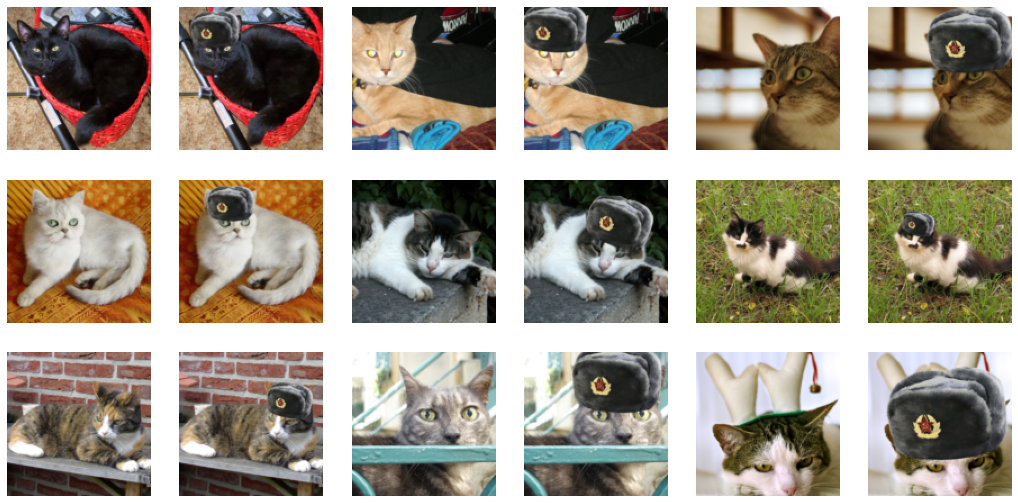

In [ ]:
dls = dblock.dataloaders(source, bs=30); dls.c = 3
dls.show_batch()

In [ ]:
feat_m = prepare_feat_model(vgg16_bn(True).features)
get_fts = LayerFeats(feat_m, stl_ls=[], cnt_ls=get_layers(feat_m, [12,22,32]),
                     tfms=NormalizeAll.from_stats(*imagenet_stats))

In [ ]:
cnt_loss = partial(content_loss, layer_ws=[5,15,2])
loss_func = SuperResLoss(cnt_loss=cnt_loss)

In [ ]:
cbs = [FeatsCallback(get_fts)]
metrics = loss_func.metrics
cfg = unet_config(blur=True, self_attention=True, norm_type=NormType.Weight, y_range=(0.,1.))
learn = unet_learner(dls=dls, arch=resnet34, loss_func=loss_func, cbs=cbs,
                     metrics=metrics, config=cfg)

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.0020892962347716093)

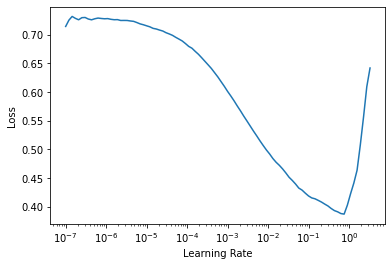

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, 1e-2, pct_start=.9)

epoch,train_loss,valid_loss,pixel,cnt,time
0,0.115926,0.110381,0.006038,0.104343,01:57
1,0.083022,0.084782,0.004810,0.079972,01:56
2,0.065074,0.063851,0.003326,0.060525,01:56


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.9054607491852948e-06)

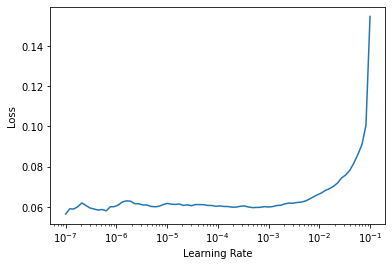

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-6,1e-4), pct_start=0.9)

epoch,train_loss,valid_loss,pixel,cnt,time
0,0.059400,0.062497,0.003239,0.059258,02:00
1,0.057013,0.061359,0.003169,0.058190,02:01
2,0.055483,0.060334,0.003114,0.057221,02:00


In [ ]:
learn.fit_one_cycle(3, slice(1e-4,1e-3), pct_start=0.1)

epoch,train_loss,valid_loss,pixel,cnt,time
0,0.056117,0.057659,0.003022,0.054637,02:00
1,0.049702,0.053545,0.002678,0.050867,02:00
2,0.044628,0.051802,0.002589,0.049213,02:00


In [ ]:
learn.fit_one_cycle(6, slice(1e-4,1e-3), pct_start=0.1)

epoch,train_loss,valid_loss,pixel,cnt,time
0,0.048227,0.052641,0.002656,0.049985,02:00
1,0.045547,0.051855,0.002629,0.049227,02:00
2,0.042395,0.047912,0.002390,0.045522,02:00
3,0.038815,0.047082,0.002375,0.044707,02:00
4,0.034843,0.045695,0.002303,0.043391,02:00
5,0.034346,0.045343,0.002279,0.043063,02:00


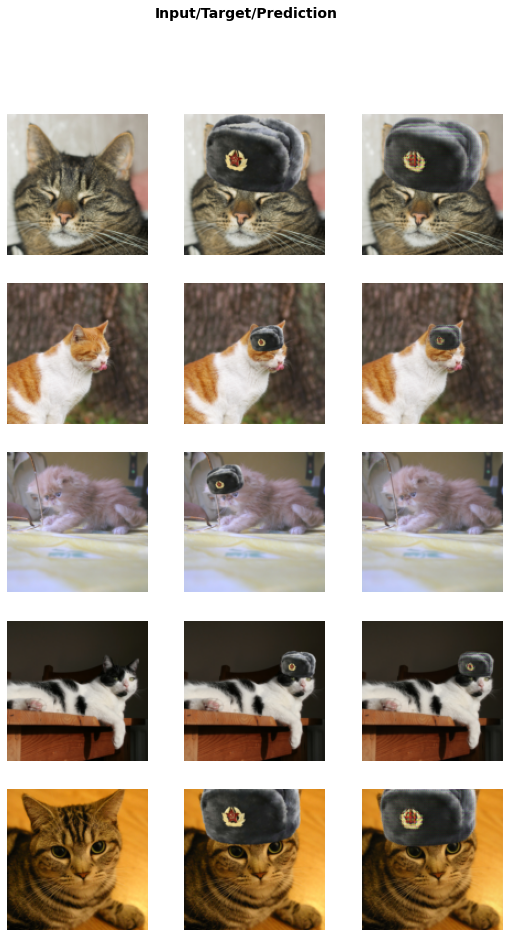

In [ ]:
learn.show_results()

In [ ]:
learn.save('hats_on_cats')

Path('models/hats_on_cats.pth')